In [1]:
import pandas as pd
import tensorflow
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense,Dropout,Activation,Conv2D,Reshape
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils import *
import math
import time
import matplotlib.pyplot as plt

/home/ubuntu/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
df = pd.read_csv('data/2330+Us.csv')

In [14]:
df.head()

,Date,Open,High,Low,Close,SMA5,SMA10,SMA20,SMA60,Vol,MA5,MA10,DIF,MACD9,OSC,K,D,S_P500,SOXX,ADR
0,2011/7/20,69.7,71.7,69.4,71.6,70.08,70.83,71.79,74.02,58272,59446,55917,-1.15,-1.00,-0.15,32.35%,26.05%,1326.73,397.41,12.22
1,2011/7/21,71.4,71.6,70.6,71.6,70.26,70.83,71.66,74.05,33277,55219,54470,-1.04,-1.01,-0.03,46.77%,32.96%,1325.84,395.11,12.47
2,2011/7/22,72.4,72.4,71.7,72.0,70.68,70.78,71.62,74.04,38244,45044,52998,-0.88,-0.98,0.10,60.35%,42.09%,1343.80,398.88,12.57
3,2011/7/25,72.4,72.5,71.4,72.0,71.14,70.85,71.62,74.02,34963,44443,51283,-0.76,-0.94,0.18,69.40%,51.19%,1345.02,408.56,12.98
4,2011/7/26,72.3,73.7,72.3,73.7,72.18,71.19,71.68,74.03,53159,43583,52599,-0.54,-0.86,0.32,79.60%,60.66%,1337.43,403.08,12.75


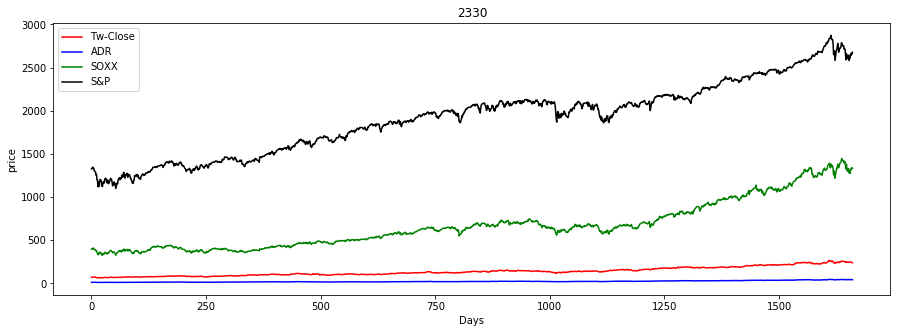

In [17]:
plt.figure(figsize = (15,5))
plt.plot(df.Close.values , color='red' , label='Tw-Close')
plt.plot(df.ADR.values , color='blue' , label='ADR')
plt.plot(df.SOXX.values , color='green' , label= 'SOXX')
plt.plot(df.S_P500.values , color='black' , label='S&P')

plt.title('2330')
plt.xlabel('Days')
plt.ylabel('price')
plt.legend(loc='best')
plt.show()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1661 entries, 0 to 1660
Data columns (total 20 columns):
Date            1661 non-null object
Open            1661 non-null float64
High            1661 non-null float64
Low             1661 non-null float64
Close           1661 non-null float64
SMA5            1661 non-null float64
SMA10           1661 non-null float64
SMA20           1661 non-null float64
SMA60           1661 non-null float64
Vol             1661 non-null int64
MA5             1661 non-null int64
MA10            1661 non-null int64
DIF             1661 non-null float64
MACD9           1661 non-null float64
OSC             1661 non-null float64
K               1661 non-null object
D               1661 non-null object
Close S&P500    1661 non-null float64
Close SOXX      1661 non-null float64
Close ADR       1661 non-null float64
dtypes: float64(14), int64(3), object(3)
memory usage: 259.6+ KB


In [5]:
def batch_data( time_steps,sd,batch_size,feature_list):

    df = pd.read_csv('data/2330.csv')

    
    
#     del df['Date']
#     del df['DIF']
#     del df['K']
#     del df['D']
#     del df['MACD9']
#     del df['OSC']
#     del df['SMA60']
#     del df['MA10']
#     del df['MA5']
#     del df['SMA20']
#     del df['SMA10']

    #_data = df.drop(['Date'],['DIF'],['K'],['D'],['MACD9'],['OSC'], axis=1)
    #df.drop(['Date'],axis=1)
    # df.drop(['DIF'],axis=1)
    # df.drop(['K'],axis=1)
    # df.drop(['D'],axis=1)
    # df.drop(['MACD9'],axis=1)
    # df.drop(['OSC'],axis=1)
    df['K'] = df['K'].str.replace('%','').astype('float')
    df['K'] = df['K'] * 0.01
    
    df['D'] = df['D'].str.replace('%','').astype('float')
    df['D'] = df['D'] * 0.01

    df['Vol']= df['Vol'].astype('float')
    df['Open'] = df['Open'].astype('float')
    df['High'] = df['High'].astype('float')
    df['Low'] = df['Low'].astype('float')
    df['Close'] = df['Close'].astype('float')
    df['SMA5'] = df['SMA5'].astype('float')
    df['SMA10'] = df['SMA10'].astype('float')
    df['SMA20'] = df['SMA20'].astype('float')
    df['SMA60'] = df['SMA60'].astype('float')
    df['MA5'] = df['MA5'].astype('float')
    df['MA10'] = df['MA10'].astype('float')
    
    

    sd = 7  

    df['label']=(df['Close'].shift(sd)-df['Close']>=0).astype('int')


    Y =df['label']
    Y = np_utils.to_categorical(Y)
    #first time train
    #X = df[['Vol','Open','High','Low','Close']]
    # acc 65
    
    #second
    #X = df[['Vol','Open','High','Low','Close','MA5']]
    
    #third
    #X = df[['Vol','Open','High','Low','Close','MA5','MA10']]
    
    #4
    X = df[feature_list]
    
    #X = df[['Vol','Open','High','Low','Close','MA5','MA10','SMA5','SMA10','SMA20']]
    

    Y = np.array(Y)
    X = np.array(X)
    
    m = MinMaxScaler(feature_range=(0,1))
    X=m.fit_transform(X)

    X_t = []
    Y_t = []
    
    
    
    
    for i in range(0, X.shape[0] - time_steps):
        

        X_t.append(X[i:i+time_steps])
        Y_t.append(Y[i+time_steps])
    X_t = np.array(X_t)
    Y_t = np.array(Y_t)
    
    dn = X_t.shape[0]%batch_size
    X_t = X_t[dn:]
    Y_t = Y_t[dn:]
    
    
      
#     X_t,Y_t=shuffle(X_t, Y_t, random_state=0)
    
    X_t_batch_train=X_t[:-batch_size]
    Y_t_batch_train=Y_t[:-batch_size]

    X_t_batch_test=X_t[-batch_size:]
    Y_t_batch_test=Y_t[-batch_size:]
    return X_t_batch_train,Y_t_batch_train,X_t_batch_test,Y_t_batch_test,df
    
    

In [6]:
df.head()

,Date,Open,High,Low,Close,SMA5,SMA10,SMA20,SMA60,Vol,MA5,MA10,DIF,MACD9,OSC,K,D,Close S&P500,Close SOXX,Close ADR
0,2011/7/20,69.7,71.7,69.4,71.6,70.08,70.83,71.79,74.02,58272,59446,55917,-1.15,-1.00,-0.15,32.35%,26.05%,1326.73,397.41,12.22
1,2011/7/21,71.4,71.6,70.6,71.6,70.26,70.83,71.66,74.05,33277,55219,54470,-1.04,-1.01,-0.03,46.77%,32.96%,1325.84,395.11,12.47
2,2011/7/22,72.4,72.4,71.7,72.0,70.68,70.78,71.62,74.04,38244,45044,52998,-0.88,-0.98,0.10,60.35%,42.09%,1343.80,398.88,12.57
3,2011/7/25,72.4,72.5,71.4,72.0,71.14,70.85,71.62,74.02,34963,44443,51283,-0.76,-0.94,0.18,69.40%,51.19%,1345.02,408.56,12.98
4,2011/7/26,72.3,73.7,72.3,73.7,72.18,71.19,71.68,74.03,53159,43583,52599,-0.54,-0.86,0.32,79.60%,60.66%,1337.43,403.08,12.75


In [7]:
df.shape

(1661, 20)

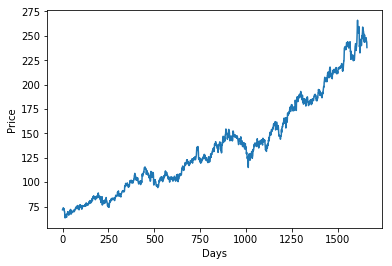

In [8]:
#dates = pd.to_datetime(df['Date'] , format='%Y%m%d')
plt.plot(df['Close'])
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

In [67]:
batch_size= 128
LR= 0.001
epoch= 1000
input_size= 6
time_steps= 6
sd = 5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(batch_input_shape=(128, 6, 6..., return_sequences=True, stateful=False, units=256)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, stateful=False, units=128)`
  


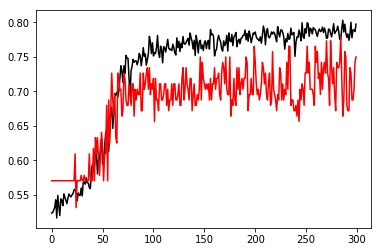

predict_days: 0 - 5
-----------
pre : [0 0 0 0 0]
Y   : [0 0 0 0 0]
1.0



predict_days: 5 - 10
-----------
pre : [0 0 0 0 0]
Y   : [0 0 0 0 0]
1.0



predict_days: 10 - 15
-----------
pre : [1 1 1 1 1]
Y   : [0 0 0 1 0]
0.19999999999999996



predict_days: 15 - 20
-----------
pre : [1 1 1 0 0]
Y   : [0 0 0 0 0]
0.4



predict_days: 20 - 25
-----------
pre : [0 1 1 1 1]
Y   : [0 0 0 1 1]
0.6



predict_days: 25 - 30
-----------
pre : [1 1 1 1 1]
Y   : [1 1 0 1 1]
0.8



predict_days: 30 - 35
-----------
pre : [1 1 0 0 0]
Y   : [1 1 0 0 0]
1.0



predict_days: 35 - 40
-----------
pre : [0 0 1 1 1]
Y   : [0 1 1 1 1]
0.8



predict_days: 40 - 45
-----------
pre : [1 1 1 1 1]
Y   : [1 1 1 1 1]
1.0



predict_days: 45 - 50
-----------
pre : [1 1 1 0 0]
Y   : [1 0 1 1 0]
0.6



predict_days: 50 - 55
-----------
pre : [0 0 0 0 1]
Y   : [0 0 1 1 1]
0.6



predict_days: 55 - 60
-----------
pre : [1 0 0 0 0]
Y   : [0 1 1 1 0]
0.19999999999999996



predict_days: 60 - 65
-----------
pre : [0 0 0 

In [40]:

    
model =Sequential()
model.add(LSTM(
            batch_input_shape=(batch_size,time_steps,input_size),
            output_dim=256,
            return_sequences=True,
            stateful=False,
        ))
model.add(Dropout(0.6))
model.add(LSTM(
        output_dim=128,
            return_sequences=False,
            stateful=False,
         ))
model.add(Dropout(0.6))
model.add(Dense(256))
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Dropout(0.4))
model.add(Dense(64))
model.add(Dropout(0.4))
model.add(Dense(2,activation='softmax'))
adam = Adam(LR)
#     model.summary()
model.compile(optimizer=adam,
                  loss='categorical_crossentropy',metrics=['accuracy'])
X_t_batch_train,Y_t_batch_train,X_t_batch_test,Y_t_batch_test,df=batch_data(time_steps,-sd,batch_size)
train_history=model.fit(X_t_batch_train, Y_t_batch_train, epochs=epoch, batch_size=batch_size,verbose=0,validation_data=(X_t_batch_test,Y_t_batch_test),shuffle=True)
plt.plot(train_history.history['acc'],color='black')
plt.plot(train_history.history['val_acc'],color='red')

plt.show()
days=[5,10,15,20,25,30,35,40,45,50,55,60]
pre = model.predict(X_t_batch_test,batch_size=batch_size)
pre = np.where(pre>0.5,1,0)
pre1 = pre[:,1]
Y_t_batch_test1 = Y_t_batch_test[:,1] 
Y_t_batch_test1=Y_t_batch_test1.astype(int)
days=[0,5,10,15,20,25,30,35,40,45,50,55,60]
pd.crosstab(pre1[:5],Y_t_batch_test1[:5],rownames=['label'],colnames=['pre'])
for i in days:
    print('predict_days:',i,'-',i+5)
    print('-----------')
    print("pre :",pre1[i:i+5])
    print("Y   :",Y_t_batch_test1[i:i+5])
    print((1-sum((pre1[i:i+5]-Y_t_batch_test1[i:i+5])**2)/5))

    print('\n\n')

In [71]:
#feature_list_try = ['SMA5', 'SMA10', 'SMA20',
       #'SMA60', 'MA5', 'MA10', 'DIF', 'MACD9', 'OSC', 'K', 'D']
feature_list_try = ['OSC','K','MACD9']

new feature:  OSC


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(batch_input_shape=(128, 6, 8..., return_sequences=True, stateful=False, units=256)`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, stateful=False, units=128)`


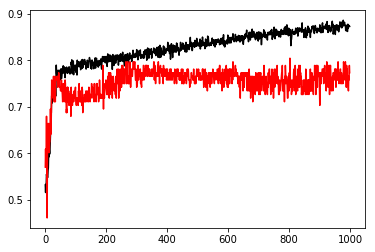

1408/1408 [==============================] - 0s 34us/step
train_score: [0.25767733427611267, 0.8828125]
128/128 [==============================] - 0s 32us/step
test_score: [1.4697948694229126, 0.7734375]
new feature:  K


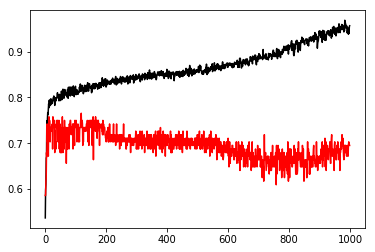

1408/1408 [==============================] - 0s 35us/step
train_score: [0.060736793178049, 0.9744318181818182]
128/128 [==============================] - 0s 32us/step
test_score: [2.4584360122680664, 0.6953125]
new feature:  MACD9


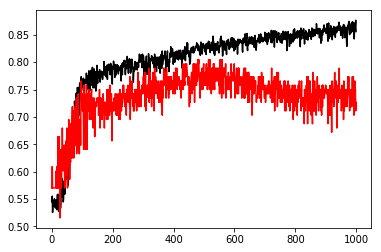

1408/1408 [==============================] - 0s 39us/step
train_score: [0.3093758902766488, 0.8650568181818182]
128/128 [==============================] - 0s 39us/step
test_score: [0.6398221254348755, 0.7265625]


In [72]:

for i in range(len(feature_list_try)):
    feature_list = ['Open', 'High', 'Low', 'Close','Vol','SMA5', 'SMA10']
    feature_list.append(feature_list_try[i])
    input_size = len(feature_list)
    print('new feature: ',feature_list_try[i])
    model =Sequential()
    model.add(LSTM(
                batch_input_shape=(batch_size,time_steps,input_size),
                output_dim=256,
                return_sequences=True,
                stateful=False,
            ))
    model.add(Dropout(0.6))
    model.add(LSTM(
            output_dim=128,
                return_sequences=False,
                stateful=False,
             ))
    model.add(Dropout(0.6))
    model.add(Dense(256))
    model.add(Dropout(0.4))
    model.add(Dense(128))
    model.add(Dropout(0.4))
    model.add(Dense(64))
    model.add(Dropout(0.4))
    model.add(Dense(2,activation='softmax'))
    adam = Adam(LR)
    #     model.summary()
    model.compile(optimizer=adam,
                      loss='categorical_crossentropy',metrics=['accuracy'])
    X_t_batch_train,Y_t_batch_train,X_t_batch_test,Y_t_batch_test,df=batch_data(time_steps,-sd,batch_size,feature_list)
    train_history=model.fit(X_t_batch_train, Y_t_batch_train, epochs=epoch, batch_size=batch_size,verbose=0,validation_data=(X_t_batch_test,Y_t_batch_test),shuffle=True)
    plt.plot(train_history.history['acc'],color='black')
    plt.plot(train_history.history['val_acc'],color='red')
#     df['K'] = df['K'] * 0.01
#     df['K'] = df['K'] * 0.01
    plt.show()
#     days=[5,10,15,20,25,30,35,40,45,50,55,60]
#     pre = model.predict(X_t_batch_test,batch_size=batch_size)
#     pre = np.where(pre>0.5,1,0)
#     pre1 = pre[:,1]
#     Y_t_batch_test1 = Y_t_batch_test[:,1] 
#     Y_t_batch_test1=Y_t_batch_test1.astype(int)
#     days=[0,5,10,15,20,25,30,35,40,45,50,55,60]
#     pd.crosstab(pre1[:5],Y_t_batch_test1[:5],rownames=['label'],colnames=['pre'])
#     for i in days:
#         print('predict_days:',i,'-',i+5)
#         print('-----------')
#         print("pre :",pre1[i:i+5])
#         print("Y   :",Y_t_batch_test1[i:i+5])
#         print((1-sum((pre1[i:i+5]-Y_t_batch_test1[i:i+5])**2)/5))

#         print('\n\n')
    score = model.evaluate(X_t_batch_train,Y_t_batch_train, verbose=1,batch_size=128)
    print('train_score:', score)
    score = model.evaluate(X_t_batch_test,Y_t_batch_test, verbose=1,batch_size=128)
    print('test_score:', score)